In [1]:
#import librairies

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import warnings
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV

color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew #for some statistics

# Mute warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
train = train.drop('Id',axis=1)
test = test.drop('Id',axis=1)

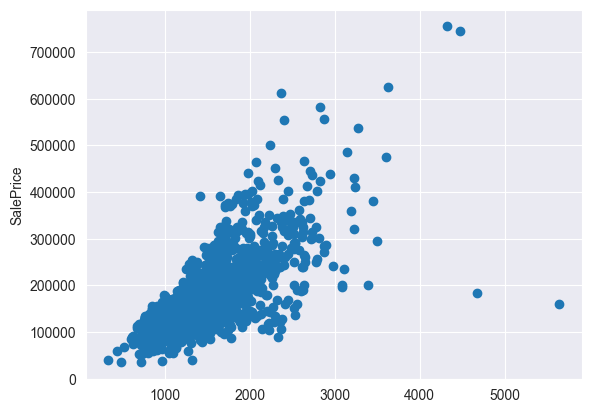

In [6]:
fig,ax = plt.subplots()
ax.scatter(x=train['GrLivArea'],y=train['SalePrice'])
plt.xlabel=('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

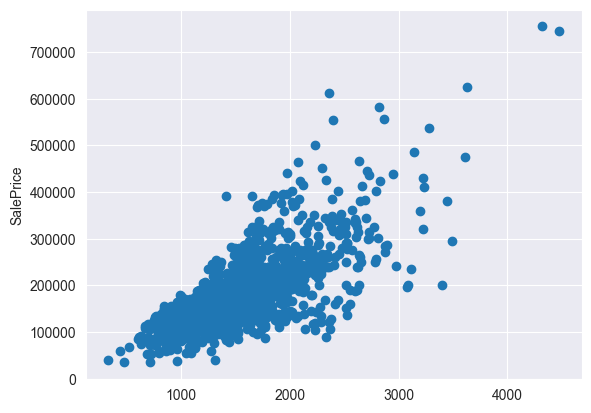

In [7]:
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice']<200000)].index)
fig,ax = plt.subplots()
ax.scatter(x=train['GrLivArea'],y=train['SalePrice'])
plt.xlabel=('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

In [8]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1458.000,1199.000,1458.000,1458.000,1458.000,1458.000,1458.000,1450.000,1458.000,1458.000,...,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000,1458.000
mean,56.893,69.797,10459.937,6.094,5.576,1971.218,1984.834,102.754,438.827,46.613,...,94.084,46.246,21.984,3.414,15.082,2.433,43.549,6.323,2007.816,180932.919
std,42.329,23.203,9859.198,1.376,1.113,30.194,20.642,179.442,432.969,161.421,...,125.350,65.313,61.156,29.337,55.793,38.210,496.461,2.700,1.329,79495.055
min,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,20.000,59.000,7544.500,5.000,5.000,1954.000,1967.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129925.000
50%,50.000,69.000,9475.000,6.000,5.000,1972.500,1994.000,0.000,382.000,0.000,...,0.000,24.500,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,70.000,80.000,11600.000,7.000,6.000,2000.000,2004.000,164.750,711.000,0.000,...,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,2188.000,1474.000,...,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1458 non-null   int64  
 1   MSZoning       1458 non-null   object 
 2   LotFrontage    1199 non-null   float64
 3   LotArea        1458 non-null   int64  
 4   Street         1458 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1458 non-null   object 
 7   LandContour    1458 non-null   object 
 8   Utilities      1458 non-null   object 
 9   LotConfig      1458 non-null   object 
 10  LandSlope      1458 non-null   object 
 11  Neighborhood   1458 non-null   object 
 12  Condition1     1458 non-null   object 
 13  Condition2     1458 non-null   object 
 14  BldgType       1458 non-null   object 
 15  HouseStyle     1458 non-null   object 
 16  OverallQual    1458 non-null   int64  
 17  OverallCond    1458 non-null   int64  
 18  YearBuilt    

In [10]:
nan_counts = train.isna().sum()

for column, count in nan_counts.items():
    print(f"{column} - {count}  NaN")

MSSubClass - 0  NaN
MSZoning - 0  NaN
LotFrontage - 259  NaN
LotArea - 0  NaN
Street - 0  NaN
Alley - 1367  NaN
LotShape - 0  NaN
LandContour - 0  NaN
Utilities - 0  NaN
LotConfig - 0  NaN
LandSlope - 0  NaN
Neighborhood - 0  NaN
Condition1 - 0  NaN
Condition2 - 0  NaN
BldgType - 0  NaN
HouseStyle - 0  NaN
OverallQual - 0  NaN
OverallCond - 0  NaN
YearBuilt - 0  NaN
YearRemodAdd - 0  NaN
RoofStyle - 0  NaN
RoofMatl - 0  NaN
Exterior1st - 0  NaN
Exterior2nd - 0  NaN
MasVnrType - 872  NaN
MasVnrArea - 8  NaN
ExterQual - 0  NaN
ExterCond - 0  NaN
Foundation - 0  NaN
BsmtQual - 37  NaN
BsmtCond - 37  NaN
BsmtExposure - 38  NaN
BsmtFinType1 - 37  NaN
BsmtFinSF1 - 0  NaN
BsmtFinType2 - 38  NaN
BsmtFinSF2 - 0  NaN
BsmtUnfSF - 0  NaN
TotalBsmtSF - 0  NaN
Heating - 0  NaN
HeatingQC - 0  NaN
CentralAir - 0  NaN
Electrical - 1  NaN
1stFlrSF - 0  NaN
2ndFlrSF - 0  NaN
LowQualFinSF - 0  NaN
GrLivArea - 0  NaN
BsmtFullBath - 0  NaN
BsmtHalfBath - 0  NaN
FullBath - 0  NaN
HalfBath - 0  NaN
BedroomAbv

In [11]:
train.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

In [12]:
#Cleaning
train["Exterior2nd"] = train["Exterior2nd"].replace({"Brk Cmn": "Br kComm"})
# Some values of GarageYrBlt are corrupt, so lets replace them
    # with the year the house was built
train["GarageYrBlt"] = train["GarageYrBlt"].where(train.GarageYrBlt<= 2010,train.YearBuilt)
# rename columns beginning with numbers
train.rename(columns={
    "1stFlrSF": "FirstFlrSF",
    "2ndFlrSF": "SecondFlrSF",
    "3SsnPorch": "Threeseasonporch" 
}, inplace = True
)

In [13]:
#Missing values(replacing missing values and droping when there is too many nans)
for name in train.select_dtypes("number"):
    train[name] = train[name].fillna(0)
for name in train.select_dtypes("category"):
    trainn[name] = train[name].fillna("None")

In [14]:
# ntrain = train.shape[0]
# ntest = test.shape[0]
# y_train = train.SalePrice.values
# all_data = pd.concat((train, test)).reset_index(drop=True)
# all_data.drop(['SalePrice'], axis=1, inplace=True)
# print("all_data size is : {}".format(all_data.shape))

In [15]:
# all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
# all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
# missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
# missing_data.head(20)

In [16]:
# f, ax = plt.subplots(figsize=(15, 12))
# plt.xticks(rotation='vertical')
# sns.barplot(x=all_data_na.index, y=all_data_na)
# plt.title('Percent missing data by feature', fontsize=15)

In [17]:
#Feature Utility Scores

from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


X = train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X,y)
mi_scores

OverallQual    0.579
Neighborhood   0.526
GarageArea     0.498
GrLivArea      0.435
YearBuilt      0.414
                ... 
Utilities      0.000
MoSold         0.000
MiscVal        0.000
PoolQC         0.000
PoolArea       0.000
Name: MI Scores, Length: 79, dtype: float64

In [18]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]
X = train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)

In [19]:
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score
score_dataset(X, y)

0.13818166646182925

In [20]:
#Creating Features
train['OverallQualCond'] = train['OverallQual'].astype(int) * train['OverallCond'].astype(int)

# Square roots of area features
area_features = ['LotArea', 'TotalBsmtSF', 'GrLivArea']
for feature in area_features:
    train[f'Sqrt_{feature}'] = np.sqrt(train[feature])

# Logarithms of numeric features
numeric_features = ['LotFrontage', 'FirstFlrSF', 'SalePrice']
for feature in numeric_features:
    train[f'Log_{feature}'] = np.log1p(train[feature])

# Interactions between numeric and categorical features
train['BsmtQual_TotalBsmtSF'] = train['BsmtQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0}) * train['TotalBsmtSF']

# Group statistics in Neighborhood
group_stats = ['GrLivArea', 'SalePrice']
grouped = train.groupby('Neighborhood')[group_stats].transform('mean')
train['Mean_GrLivArea_Neighborhood'] = grouped['GrLivArea']
train['Mean_SalePrice_Neighborhood'] = grouped['SalePrice']

# Difference between GrLivArea and median
train['GrLivArea_MedianDiff'] = train['GrLivArea'] - train.groupby('Neighborhood')['GrLivArea'].transform('median')



In [21]:
X["LivLotRatio"] = train.GrLivArea / train.LotArea
X["Spaciousness"] = (train.FirstFlrSF + train.SecondFlrSF) / train.TotRmsAbvGrd
X["PorchTypes"] = train[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
X["MedNhbdArea"] = train.groupby("Neighborhood")["GrLivArea"].transform("median")

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458 entries, 0 to 1459
Data columns (total 91 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   MSSubClass                   1458 non-null   int64  
 1   MSZoning                     1458 non-null   object 
 2   LotFrontage                  1458 non-null   float64
 3   LotArea                      1458 non-null   int64  
 4   Street                       1458 non-null   object 
 5   Alley                        91 non-null     object 
 6   LotShape                     1458 non-null   object 
 7   LandContour                  1458 non-null   object 
 8   Utilities                    1458 non-null   object 
 9   LotConfig                    1458 non-null   object 
 10  LandSlope                    1458 non-null   object 
 11  Neighborhood                 1458 non-null   object 
 12  Condition1                   1458 non-null   object 
 13  Condition2             

In [23]:
X = train.copy()
y = X.pop("SalePrice")
mi_scores = make_mi_scores(X,y)
X = drop_uninformative(X, mi_scores)
score_dataset(X, y)

0.018092097732805172

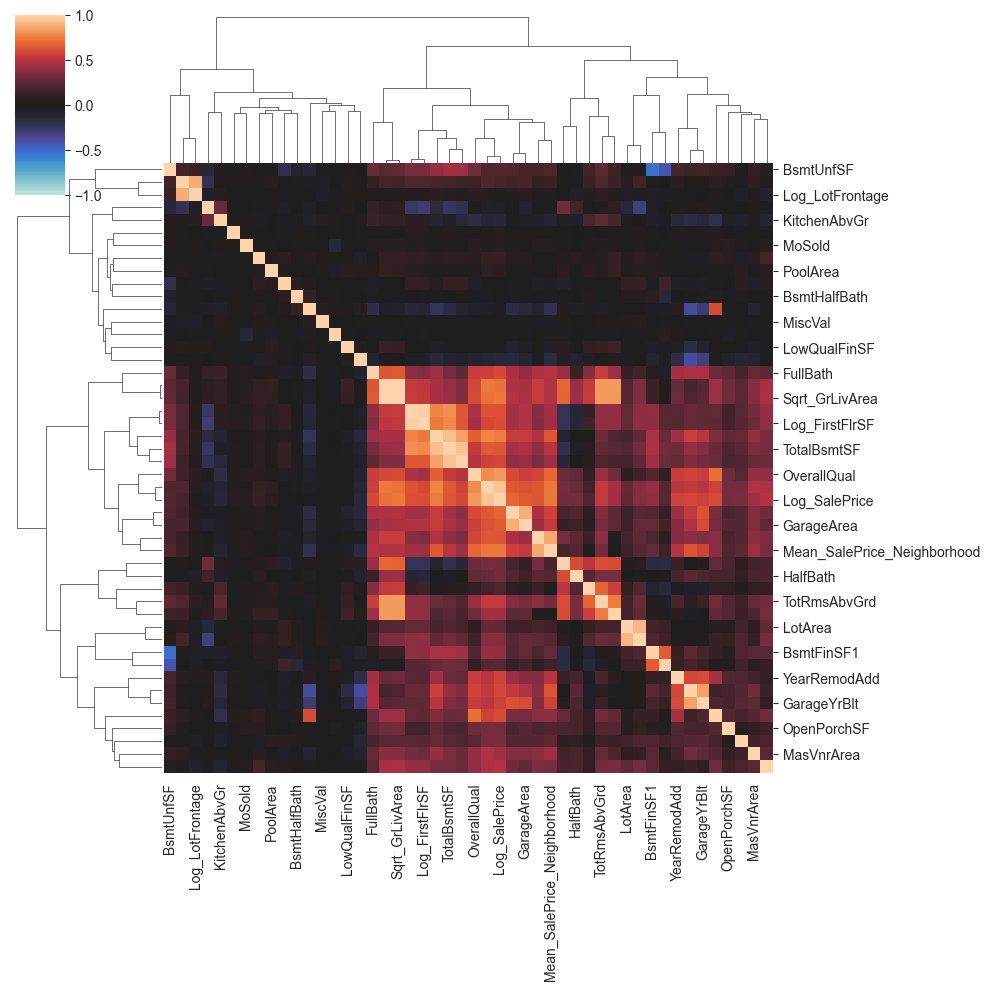

In [24]:
#correlation
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method, numeric_only=True),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(train, annot=None)

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

y = train['SalePrice']
X = train.drop(["SalePrice"], axis=1)
# Perform one-hot encoding on the categorical variables
data_encoded = pd.get_dummies(train)

# Separate the features (X) and target variable (y)
X = data_encoded.drop('SalePrice', axis=1)
y = data_encoded['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

models = [('LR', LinearRegression()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor())]
for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 233418.8129 (LR) 
RMSE: 39238.6559 (KNN) 
RMSE: 8085.8704 (CART) 
RMSE: 4192.1642 (RF) 
RMSE: 2778.2419 (GBM) 
RMSE: 5353.3088 (XGBoost) 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5117
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 192
[LightGBM] [Info] Start training from score 180731.400515
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5127
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 

In [26]:
gbr_model = GradientBoostingRegressor(random_state=46)

rmse = np.mean(np.sqrt(-cross_val_score(gbr_model, X, y, cv=5, scoring="neg_mean_squared_error")))
print(rmse)

gbr_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [500, 1500]
             }

gbr_gs_best = GridSearchCV(gbr_model,
                            gbr_params,
                            cv=3,
                            n_jobs=-1,
                            verbose=True).fit(X, y)



final_model = gbr_model.set_params(**gbr_gs_best.best_params_).fit(X, y)

rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")))
print(rmse)

2611.0091635230256
Fitting 3 folds for each of 4 candidates, totalling 12 fits
2886.6035412499355


In [27]:
# predictions

model = GradientBoostingRegressor()
model.fit(X, y)
predictions = model.predict(X_test)
#print(predictions)
# y_train = train.loc[:, "SalePrice"]
# model = GradientBoostingRegressor(**gbr_gs_best.best_params_)
# model.fit(X_train, np.log(y))
# predictions = np.exp(model.predict(X_test))
final_pred = predictions.tolist()
for i in range(len(final_pred)):
  idx = final_pred[i]
  print("Predicition: " + str(round(idx, 2)) + " Actual: " + str(y_test.iloc[i]))


Predicition: 277113.94 Actual: 278000
Predicition: 259182.36 Actual: 260000
Predicition: 283210.8 Actual: 283463
Predicition: 134319.65 Actual: 134000
Predicition: 217556.37 Actual: 217000
Predicition: 267267.16 Actual: 266000
Predicition: 166390.65 Actual: 165600
Predicition: 451366.8 Actual: 451950
Predicition: 196458.92 Actual: 196500
Predicition: 314802.04 Actual: 314813
Predicition: 178500.45 Actual: 179000
Predicition: 107641.54 Actual: 107000
Predicition: 164648.91 Actual: 164000
Predicition: 156006.11 Actual: 155000
Predicition: 169566.23 Actual: 169500
Predicition: 129078.44 Actual: 129500
Predicition: 90169.91 Actual: 90350
Predicition: 144788.84 Actual: 144500
Predicition: 128059.88 Actual: 128000
Predicition: 271797.71 Actual: 271000
Predicition: 274975.0 Actual: 275000
Predicition: 231671.64 Actual: 233170
Predicition: 143020.93 Actual: 143000
Predicition: 119037.25 Actual: 119200
Predicition: 172906.84 Actual: 172500
Predicition: 82297.72 Actual: 82500
Predicition: 149248

In [29]:

score_dataset(X, y)

0.017870067098888658